In [2]:
# -*- coding:utf-8  -*-
import os
import time
import json
import argparse
import numpy as np

from env.chooseenv import make
from utils.get_logger import get_logger
from env.obs_interfaces.observation import obs_type


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def get_players_and_action_space_list(g):
    if sum(g.agent_nums) != g.n_player:
        raise Exception("agent number = %d 不正确，与n_player = %d 不匹配" % (sum(g.agent_nums), g.n_player))

    n_agent_num = list(g.agent_nums)
    #print("n_agent_num: ", n_agent_num)
    for i in range(1, len(n_agent_num)):
        n_agent_num[i] += n_agent_num[i - 1]

    # 根据agent number 分配 player id
    players_id = []
    actions_space = []
    for policy_i in range(len(g.obs_type)):
        if policy_i == 0:
            players_id_list = range(n_agent_num[policy_i])
        else:
            players_id_list = range(n_agent_num[policy_i - 1], n_agent_num[policy_i])
        players_id.append(players_id_list)

        action_space_list = [g.get_single_action_space(player_id) for player_id in players_id_list]
        actions_space.append(action_space_list)

    return players_id, actions_space


def get_joint_action_eval(game, multi_part_agent_ids, policy_list, actions_spaces, all_observes):
    if len(policy_list) != len(game.agent_nums):
        error = "模型个数%d与玩家个数%d维度不正确！" % (len(policy_list), len(game.agent_nums))
        raise Exception(error)

    # [[[0, 0, 0, 1]], [[0, 1, 0, 0]]]
    joint_action = []
    for policy_i in range(len(policy_list)):

        if game.obs_type[policy_i] not in obs_type:
            raise Exception("可选obs类型：%s" % str(obs_type))

        agents_id_list = multi_part_agent_ids[policy_i]

        action_space_list = actions_spaces[policy_i]
        function_name = 'm%d' % policy_i
        for i in range(len(agents_id_list)):
            agent_id = agents_id_list[i]
            a_obs = all_observes[agent_id]
            each = eval(function_name)(a_obs, action_space_list[i], game.is_act_continuous)
            joint_action.append(each)
    return joint_action


def set_seed(g, env_name):
    if env_name.split("-")[0] in ['magent']:
        g.reset()
        seed = g.create_seed()
        g.set_seed(seed)


def run_game(g, env_name, multi_part_agent_ids, actions_spaces, policy_list, render_mode, if_render):
    """
    This function is used to generate log for Vue rendering. Saves .json file
    """
    log_path = os.getcwd() + '/logs/'
    if not os.path.exists(log_path):
        os.mkdir(log_path)

    logger = get_logger(log_path, g.game_name, json_file=render_mode)
    set_seed(g, env_name)
    """
    for i in range(len(policy_list)):
        if policy_list[i] not in get_valid_agents():
            raise Exception("agents {} not valid!".format(policy_list[i]))

        file_path = os.path.dirname(os.path.abspath(__file__)) + "/agent/" + policy_list[i] + "/submission.py"
        if not os.path.exists(file_path):
            raise Exception("file {} not exist!".format(file_path))
        import_path = '.'.join(file_path.split('/')[-3:])[:-3]
        function_name = 'm%d' % i
        import_name = "my_controller"
        import_s = "from %s import %s as %s" % (import_path, import_name, function_name)
        print(import_s)
        exec(import_s, globals())
    """
    st = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    game_info = {"game_name": env_name,
                 "n_player": g.n_player,
                 "board_height": g.board_height if hasattr(g, "board_height") else None,
                 "board_width": g.board_width if hasattr(g, "board_width") else None,
                 "init_info": g.init_info,
                 "start_time": st,
                 "mode": "terminal",
                 "seed": g.seed if hasattr(g, "seed") else None,
                 "map_size": g.map_size if hasattr(g, "map_size") else None}

    steps = []
    all_observes = g.all_observes
    while not g.is_terminal():
        step = "step%d" % g.step_cnt
        if g.step_cnt % 10 == 0:
            print(step)
        """
        if if_render:
            if hasattr(g, 'render'):
                g.render()
            else:
                if hasattr(g, "env_core"):
                    if hasattr(g.env_core, "render"):
                        g.env_core.render()
        """
        info_dict = {}
        info_dict["time"] = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
        joint_act = get_joint_action_eval(g, multi_part_agent_ids, policy_list, actions_spaces, all_observes)
        all_observes, reward, done, info_before, info_after = g.step(joint_act)
        if env_name.split("-")[0] in ["magent"]:
            info_dict["joint_action"] = g.decode(joint_act)
        if info_before:
            info_dict["info_before"] = info_before
        info_dict["reward"] = reward
        if info_after:
            info_dict["info_after"] = info_after
        steps.append(info_dict)
        #test
        """
        print("----start info dict--------")
        print(all_observes, reward, done, info_before, info_after)
        print("----end  info  dict--------")
        """
    game_info["steps"] = steps
    game_info["winner"] = g.check_win()
    game_info["winner_information"] = g.won
    game_info["n_return"] = g.n_return
    game_info["names"] = policy_list
    ed = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    game_info["end_time"] = ed
    logs = json.dumps(game_info, ensure_ascii=False, cls=NpEncoder)
    logger.info(logs)


def get_valid_agents():
    dir_path = os.path.join(os.path.dirname(__file__), 'agent')
    return [f for f in os.listdir(dir_path) if f != "__pycache__"]

"""
if __name__ == "__main__":
    # env_type = "fourplayers_nolimit_texas_holdem"
    parser = argparse.ArgumentParser()
    parser.add_argument("--env", type=str, default='fourplayers_nolimit_texas_holdem', help='fourplayers_nolimit_texas_holdem/'
                                                                                            'chessandcard-mahjong_v3/'
                                                                                            'bridge')
    parser.add_argument('--render', action='store_true', help='if render the env')
    parser.add_argument("--my_ai", default="dp", help="rl/dp")
    parser.add_argument("--opponent", default="random", help="rl/random")
    args = parser.parse_args()

    env_type = args.env
    game = make(env_type)

    # use replay/replay.html，upload logs/.json to replay
    render_mode = False

    policy_list = [args.my_ai, args.opponent, args.opponent, args.opponent]

    multi_part_agent_ids, actions_space = get_players_and_action_space_list(game)
    run_game(game, env_type, multi_part_agent_ids, actions_space, policy_list, render_mode, if_render=True)
"""

'\nif __name__ == "__main__":\n    # env_type = "fourplayers_nolimit_texas_holdem"\n    parser = argparse.ArgumentParser()\n    parser.add_argument("--env", type=str, default=\'fourplayers_nolimit_texas_holdem\', help=\'fourplayers_nolimit_texas_holdem/\'\n                                                                                            \'chessandcard-mahjong_v3/\'\n                                                                                            \'bridge\')\n    parser.add_argument(\'--render\', action=\'store_true\', help=\'if render the env\')\n    parser.add_argument("--my_ai", default="dp", help="rl/dp")\n    parser.add_argument("--opponent", default="random", help="rl/random")\n    args = parser.parse_args()\n\n    env_type = args.env\n    game = make(env_type)\n\n    # use replay/replay.html，upload logs/.json to replay\n    render_mode = False\n\n    policy_list = [args.my_ai, args.opponent, args.opponent, args.opponent]\n\n    multi_part_agent_ids, actions_s

Episode 0/20000 , total steps: 10 , epsilon: 1.0000 , episode reward: -105.00
Episode 500/20000 , total steps: 2859 , epsilon: 0.7146 , episode reward: -105.00
Episode 1000/20000 , total steps: 5698 , epsilon: 0.4308 , episode reward: -5.00
Episode 1500/20000 , total steps: 8191 , epsilon: 0.1816 , episode reward: -6.00
Episode 2000/20000 , total steps: 10653 , epsilon: 0.0100 , episode reward: 1.00
Episode 2500/20000 , total steps: 13259 , epsilon: 0.0100 , episode reward: -105.00
Episode 3000/20000 , total steps: 15669 , epsilon: 0.0100 , episode reward: -1.00
Episode 3500/20000 , total steps: 17940 , epsilon: 0.0100 , episode reward: -105.00
Episode 4000/20000 , total steps: 20308 , epsilon: 0.0100 , episode reward: 195.00
Episode 4500/20000 , total steps: 22414 , epsilon: 0.0100 , episode reward: -5.00
Episode 5000/20000 , total steps: 24754 , epsilon: 0.0100 , episode reward: -24.00
Episode 5500/20000 , total steps: 27179 , epsilon: 0.0100 , episode reward: -5.00
Episode 6000/2000

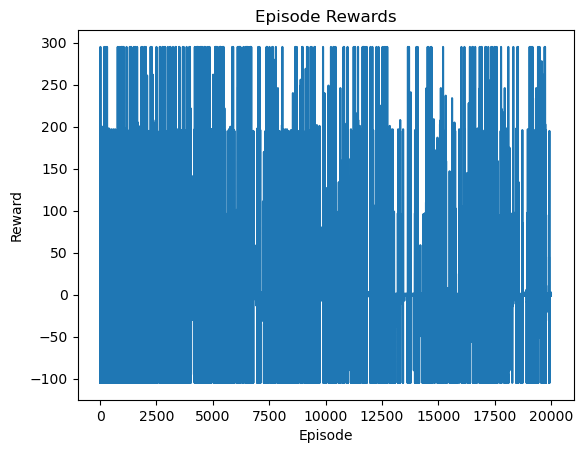

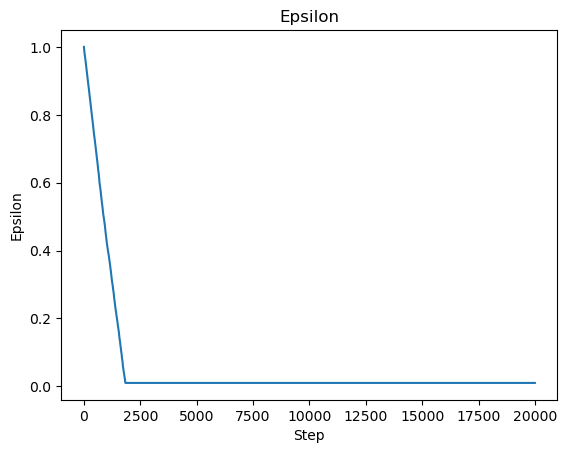

In [17]:
import torch
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
from env.chooseenv import make

# DQN 模型
class DQN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 256)
        self.fc3 = torch.nn.Linear(256, 128)
        self.fc4 = torch.nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 经验回放缓存
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, *args):
        if len(self.memory) >= self.capacity:
            self.memory.pop(0)
        self.memory.append(tuple(map(torch.tensor, args)))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN 算法
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, eps_max=1.0, eps_min=0.01, eps_decay=0.0001,\
                  memory_capacity=10000, batch_size=32, target_update_interval=100):
        self.policy_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_max = eps_max
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.steps = 0
        self.action_dim = action_dim
        self.target_update_interval = target_update_interval
        self.total_steps = 0

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            idx = random.randrange(self.action_dim)
            rtn = np.zeros(6)
            rtn[idx]=1
            return rtn
        else:
            with torch.no_grad():
                q_values = self.policy_net(state)
                idx = q_values.argmax().item()
                rtn = np.zeros(6)
                rtn[idx]=1
                return rtn

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = tuple(zip(*transitions))
        state, action, next_state, reward, done = map(torch.stack, batch)
        action = torch.argmax(action, dim=-1).unsqueeze(1)
        q_values = self.policy_net(state).gather(2, action).squeeze(2)
        #q_values = self.policy_net(state).gather(1, action.view(-1, 1).long()).squeeze(1)
        #q_values = self.policy_net(state).gather(1, action.long()).squeeze(1)
        #next_q_values = self.target_net(next_state).max(1)[0].detach()
        #next_q_values = self.target_net(next_state).max(1)[0].detach().squeeze()
        next_q_values, _ = self.target_net(next_state).max(dim=2, keepdim=True)
        #reward = reward.expand(-1, 6)
        #print(reward.shape)
        #print(q_values.shape)
        #print(next_q_values.shape)
        #print(done)
        #print(self.gamma)
        expected_q_values = reward + (1 - done) * self.gamma * next_q_values
        loss = torch.nn.functional.mse_loss(q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



    def train(self, num_episodes, print_interval=10, save_path=None, store_per_epoch=100):
        # 记录回合奖励和 epsilon 的变化
        episode_rewards = []
        epsilons = []
        # make game
        env_type = "fourplayers_nolimit_texas_holdem"
        #multi_part_agent_ids, actions_space = get_players_and_action_space_list(game)
        #run_game(game, env_type, multi_part_agent_ids, actions_space, policy_list, False, if_render=True)

        for epoch_i in range(num_episodes):
            #print(i)
            #state = env.reset()
            g = make(env_type)
            episode_reward = 0
            epsilon = max(self.eps_min, self.eps_max - self.eps_decay * self.total_steps)
            multi_part_agent_ids, action_space = get_players_and_action_space_list(g)
            all_observes = g.all_observes
            while not g.is_terminal():
                #modify this
                """
                if hasattr(g, 'render'):
                    g.render()
                else:
                    if hasattr(g, "env_core"):
                        if hasattr(g.env_core, "render"):
                            g.env_core.render()
                """
                # Sampling a round
                each_player_action=[]
                state_before_action=[]
                each_player_reward=[]
                state_after_action=[]
                joint_action=[]
                for policy_i in range(4):
                    a_obs = all_observes[policy_i]['obs']
                    if a_obs==None:
                        joint_action.append([[0,0,0,0,0,0]])
                        continue
                    agents_id_list = multi_part_agent_ids[policy_i]
                    action_space_list = action_space[policy_i]
                    for i in range(len(agents_id_list)):
                        agent_id = agents_id_list[i]
                        a_obs = all_observes[agent_id]['obs']
                        #print(a_obs)
                        state_before_action.append(a_obs['observation'])
                        each = self.select_action(torch.tensor(a_obs['observation'], dtype=torch.float32), epsilon)
                        joint_action.append([list(each)])
                        each_player_action.append(list(each))
                        #print(g.action_masks_dict)
                        # delta_reward refers to some fixing
                        """
                        if the model choose:
                            0: fold, fix -5
                            1: check, fix +1
                            2: call, fix +5
                            3: bet half pot, fix +7
                            4: bet pot, fix +9
                            5: all in, fix +11
                        if the model choose the invalid action:
                            fix -30
                        """
                        fix_reward = 0
                        if (np.array(each[0])*np.array(g.action_masks_dict['player_'+str(policy_i)])).sum()==0:
                            fix_reward = -5
                        """
                        elif each.argmax() == 0:
                            fix_reward =-2
                        elif each.argmax() == 1:
                            fix_reward =2
                        elif each.argmax() == 2:
                            fix_reward =2
                        elif each.argmax() == 3:
                            fix_reward =2
                        elif each.argmax() == 4:
                            fix_reward =2
                        elif each.argmax() == 5:
                            fix_reward =2
                        """
                        each_player_reward.append(fix_reward)
                all_observes, reward, done, info_before, info_after = g.step(joint_action)
                reward += fix_reward
                #reward *=  if reward > 25 else 1
                #print(all_observes)
                for idx in range(4):
                    if all_observes[idx]["obs"]:
                        state_after_action.append(all_observes[idx]["obs"]["observation"])
                #all_observes, reward, done, info_before, info_after = g.step(joint_action)


                #episode_reward = sum(reward, axis=1)
                #modify here
                """
                for idx in range(4):
                    for j in range(len(state_after_action)):
                        #print(len(state_after_action[i]), len(each_player_action[i]), len(state_before_action[i]), len(each_player_reward))
                    
                        print("i=",i,"j=",j,state_before_action[i][j], torch.tensor(each_player_action[i][j]),\
                                          state_after_action[i][j], torch.tensor(each_player_reward[i][j], dtype=torch.float32),\
                                          torch.tensor(done, dtype=torch.float32))
                """
                self.memory.push(state_before_action, torch.tensor(each_player_action),\
                                 state_after_action, torch.tensor(reward, dtype=torch.float32),\
                                    torch.tensor(done, dtype=torch.float32))
                """
                if g.is_terminal():
                    print(g.payoff)
                """
                self.update()

                self.steps += 1
                self.total_steps += 1
                if self.steps % self.target_update_interval == 0:
                    self.target_net.load_state_dict(self.policy_net.state_dict())

                if done:
                    break

            episode_reward += reward
            epsilons.append(epsilon)
            episode_rewards.append(episode_reward)
            
            if epoch_i % print_interval == 0:
                print("Episode {}/{} , total steps: {} , epsilon: {:.4f} , episode reward: {:.2f}".format(epoch_i, num_episodes, self.total_steps, epsilon, episode_reward))
            
            if save_path is not None and (epoch_i + 1) % store_per_epoch == 0:
                torch.save(self.policy_net.state_dict(), f"{save_path}/dqn_model_{epoch_i + 1}.pt")

        # 可视化训练结果
        plt.plot(episode_rewards)
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.show()

        plt.plot(epsilons)
        plt.title('Epsilon')
        plt.xlabel('Step')
        plt.ylabel('Epsilon')
        plt.show()

import warnings


if __name__=="__main__":
    warnings.filterwarnings('ignore')
    agent = DQNAgent(54,6)
    agent.train(20000,500,"./agent/dp",1000)
